In [1]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import resnet18
from scipy.sparse import load_npz

from tqdm import tqdm
import os
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_ROOT = "./data"
batch_size = 128
NUM_WORKERS = 4
FORGET_RATIO = 0.1
AIRPLANE_CLASS = 0  # CIFAR-100 label for "airplane"
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def evaluate_accuracy(model,test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    return round(acc,3)

In [4]:
# -----------------------
# Data
# -----------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
)

# -----------------------
# Load CScores (aligned)
# -----------------------
cscore_fn = './data/cifar100-cscores-orig-order.npz'
cscore_arrays = np.load(cscore_fn)

cscores = cscore_arrays['scores']
cs_labels = cscore_arrays['labels']  # optional, for sanity

# -----------------------
# Sanity check (once)
# -----------------------
train_targets = np.array(train_dataset.targets)
assert np.all(cs_labels == train_targets)

# ------------------------
# CScore-based forgetting
# ------------------------
airplane_idx = np.where(train_targets == AIRPLANE_CLASS)[0]
non_airplane_idx = np.where(train_targets != AIRPLANE_CLASS)[0]

# CScores for airplane samples
airplane_cscores = cscores[airplane_idx]

# sort airplane samples by ascending CScore
sorted_airplane_idx = airplane_idx[np.argsort(airplane_cscores)]

num_forget = int(len(sorted_airplane_idx) * FORGET_RATIO)

forget_idx = sorted_airplane_idx[:num_forget]
retain_airplane_idx = sorted_airplane_idx[num_forget:]

retain_idx = np.concatenate([retain_airplane_idx, non_airplane_idx])

# ------------------------
# Subsets
# ------------------------
forget_set = Subset(train_dataset, forget_idx)
retain_set = Subset(train_dataset, retain_idx)

# ------------------------
# DataLoaders
# ------------------------
forget_loader = DataLoader(
    forget_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

retain_loader = DataLoader(
    retain_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

# ------------------------
# Final sanity checks
# ------------------------
print("Forget set size:", len(forget_set))
print("Retain set size:", len(retain_set))

assert all(train_targets[i] == AIRPLANE_CLASS for i in forget_idx)
assert cscores[forget_idx].max() <= cscores[retain_airplane_idx].min()

print("CScore-based forgetting✅")

Forget set size: 50
Retain set size: 49950
CScore-based forgetting✅


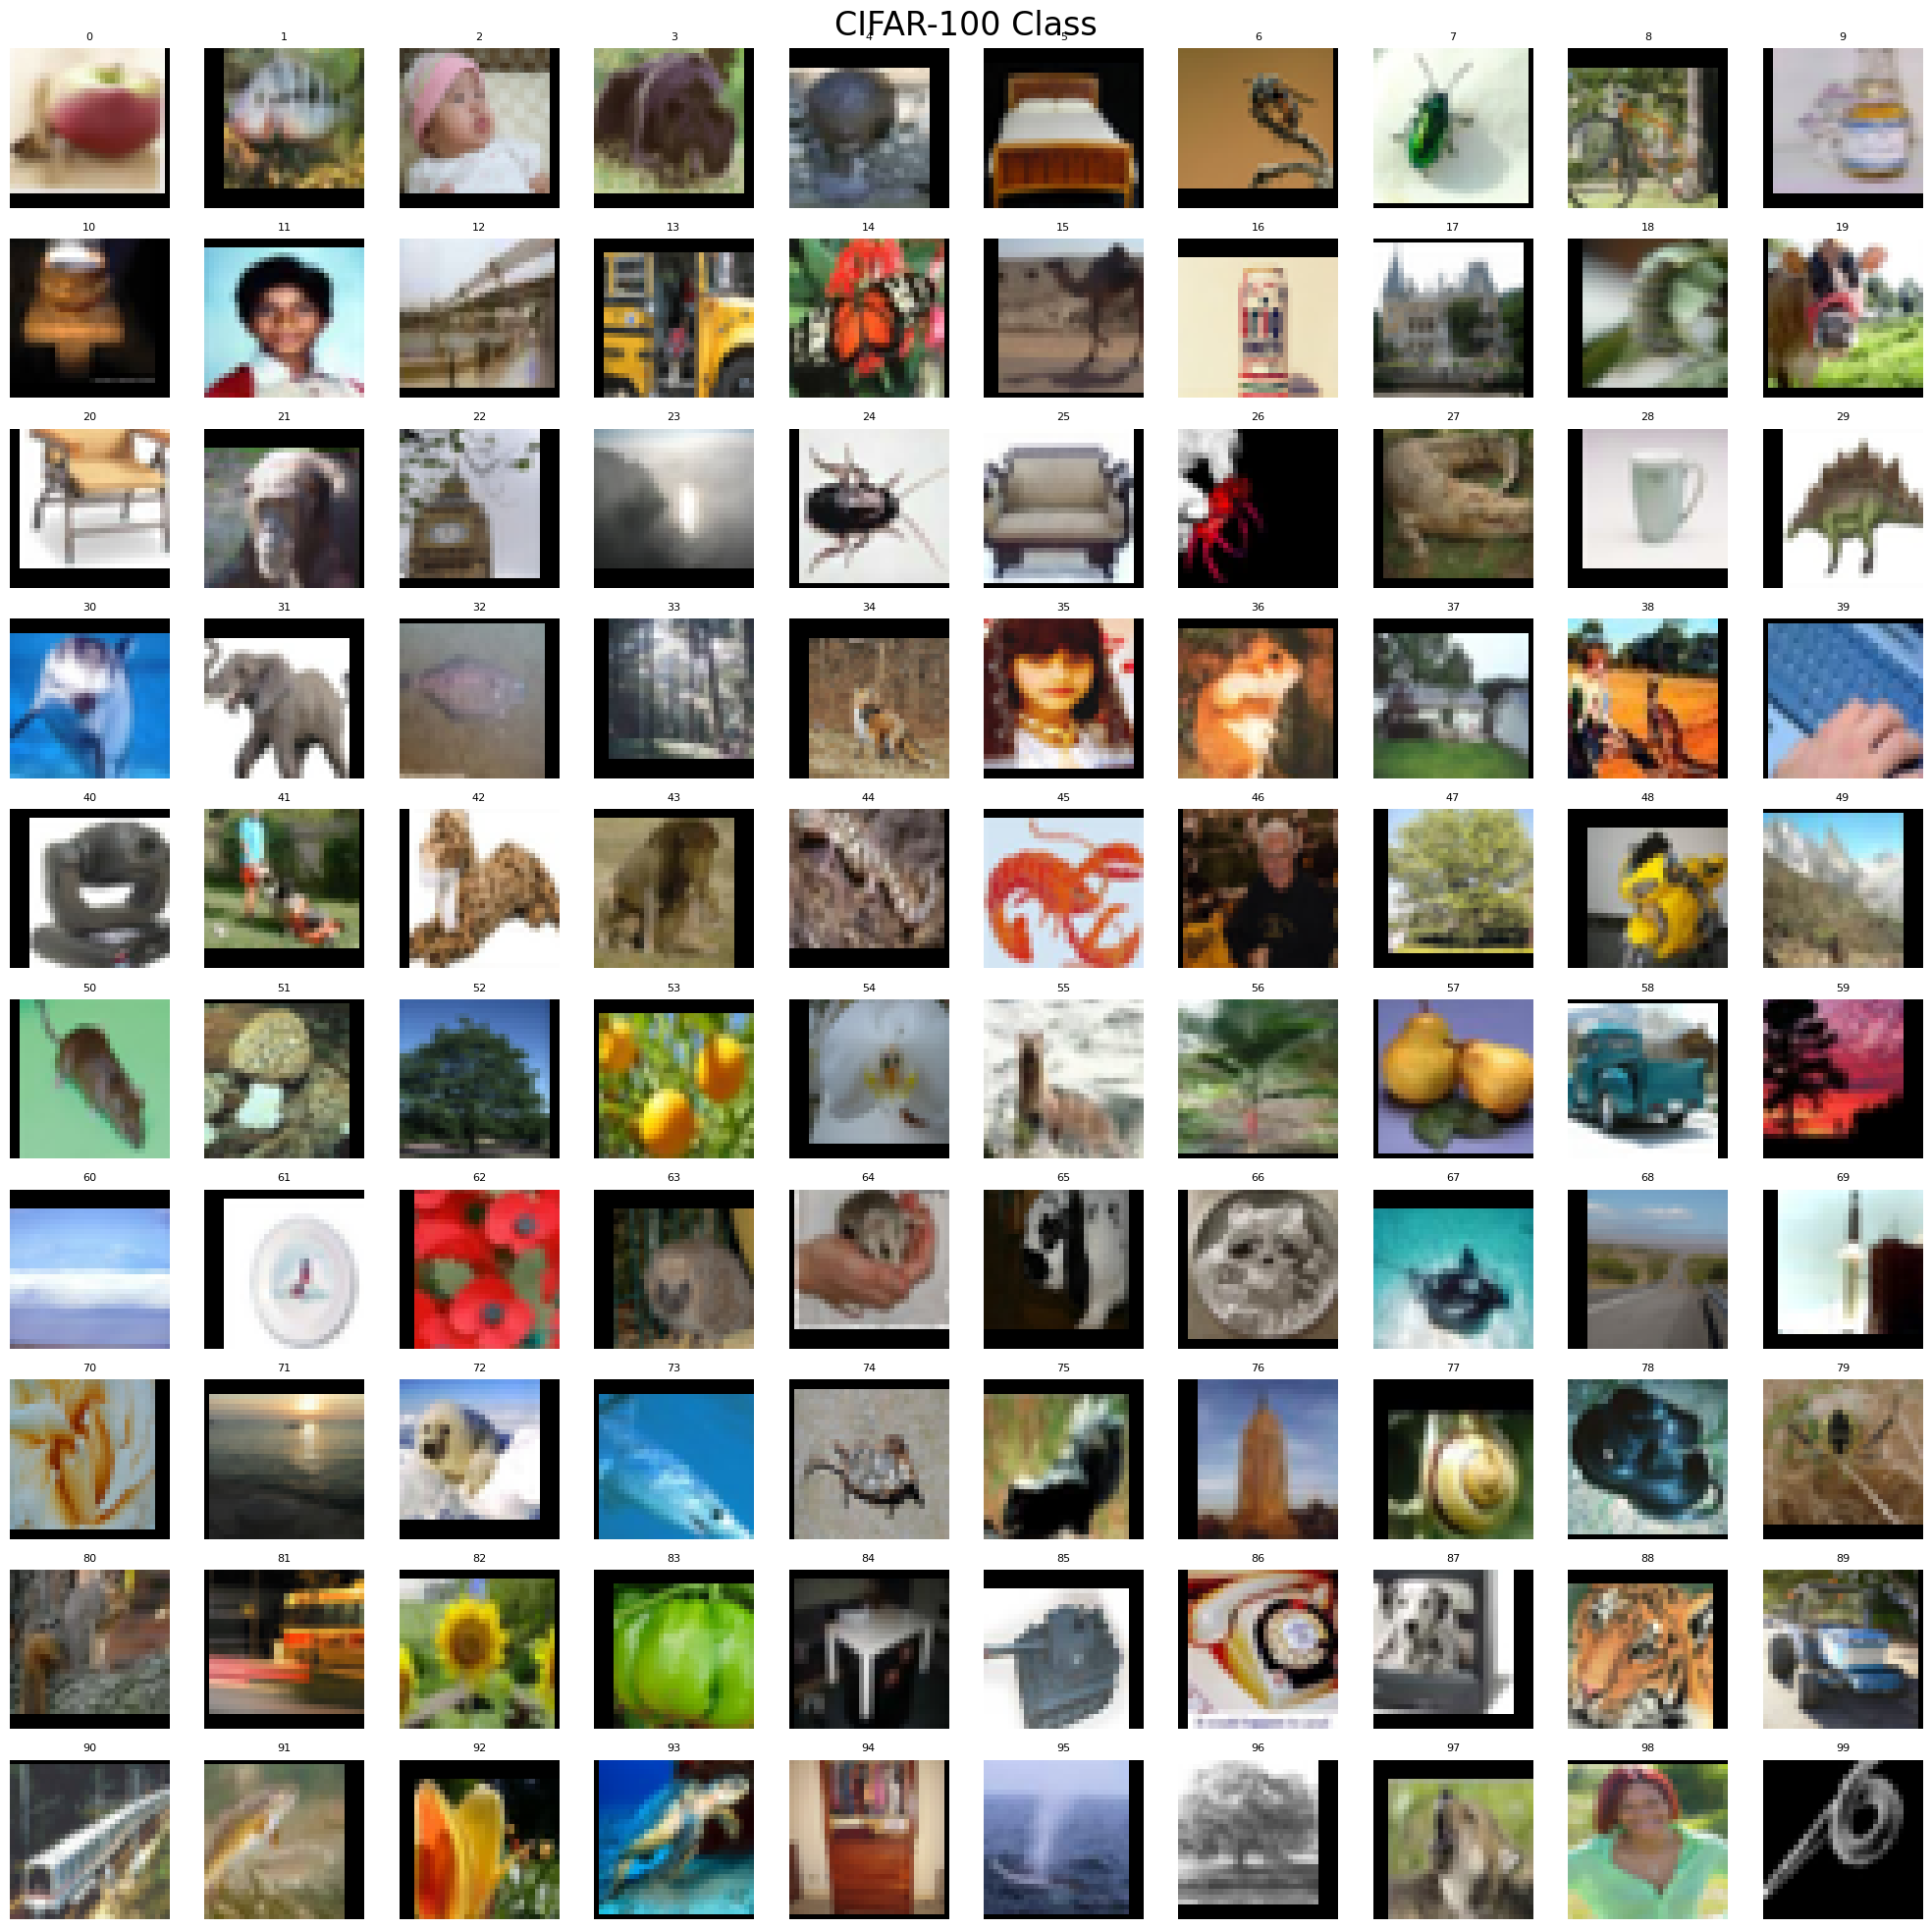

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Number of classes in CIFAR-100
num_classes = 100

# Create a dictionary to store one image per class
class_to_img = {}

# Loop over the dataset until we have one image per class
for img, label in train_dataset:
    if label not in class_to_img:
        class_to_img[label] = img
    if len(class_to_img) == num_classes:
        break

# Sort by class index for consistent ordering
class_imgs = [class_to_img[i] for i in range(num_classes)]

# Create a grid
grid_rows = 10
grid_cols = 10
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 20))
fig.suptitle("CIFAR-100 Class", fontsize=24)

for i, ax in enumerate(axes.flat):
    img = class_imgs[i]
    # If your transform includes normalization, we need to unnormalize for display
    if hasattr(transform_train, 'transforms'):
        # Check for normalization transform
        for t in transform_train.transforms:
            if isinstance(t, torchvision.transforms.Normalize):
                mean = torch.tensor(t.mean).view(3,1,1)
                std = torch.tensor(t.std).view(3,1,1)
                img = img * std + mean
                break

    np_img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    np_img = np.clip(np_img, 0, 1)         # just in case
    ax.imshow(np_img)
    ax.axis('off')
    ax.set_title(str(i), fontsize=8)

plt.tight_layout()
plt.show()

In [5]:
model = resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model = model.to(device)

checkpoint_path = "./CIFAR100_ResNet18/checkpoints/trained_model/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

In [6]:
print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(model,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.974
Test Accuracy:: 69.46


In [6]:
def relearning_attack_retain_samples(
    model,
    retain_loader,
    forget_loader,
    test_loader=None,
    epochs = 10,
    num_frac=1.0,
    lr=1e-5,
    weight_decay=0.0,
    device="cuda"
):
    """
    Relearning attack: fine-tune model on a fraction of retain data.

    Args:
        model: trained PyTorch model
        epochs: number of fine-tuning epochs
        retain_loader: DataLoader over retain set
        test_loader: optional DataLoader for evaluation
        num_frac: fraction of retain samples to use (0 < num_frac <= 1)
        lr: learning rate for relearning
        weight_decay: optimizer weight decay
        device: cpu / cuda
    """

    assert 0 < num_frac <= 1.0, "num_frac must be in (0, 1]"

    model = model.to(device)
    model.train()

    # -----------------------
    # Sample fraction of retain dataset
    # -----------------------
    retain_dataset = retain_loader.dataset
    total_samples = len(retain_dataset)
    num_samples = int(total_samples * num_frac)

    indices = np.random.permutation(total_samples)[:num_samples]
    sampled_dataset = torch.utils.data.Subset(retain_dataset, indices)

    sampled_loader = torch.utils.data.DataLoader(
        sampled_dataset,
        batch_size=retain_loader.batch_size,
        shuffle=True,
        num_workers=retain_loader.num_workers,
        pin_memory=True,
        persistent_workers=(retain_loader.num_workers > 0)
    )

    # -----------------------
    # Optimizer & loss
    # -----------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    # -----------------------
    # Fine-tuning loop
    # -----------------------
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in sampled_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

        train_loss = running_loss / len(sampled_loader)
        train_acc = 100. * correct / total

        # -----------------------
        # Optional evaluation
        # -----------------------
        if test_loader is not None:
            model.eval()
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    _, preds = outputs.max(1)
                    total += targets.size(0)
                    correct += preds.eq(targets).sum().item()

            test_acc = 100. * correct / total

            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in forget_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    _, preds = outputs.max(1)
                    total += targets.size(0)
                    correct += preds.eq(targets).sum().item()

            forget_acc = 100. * correct / total

            model.train()

        print(
            f"[Relearning] Epoch {epoch+1}/{epochs} | "
            f"Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}% | Forget Acc: {forget_acc:.2f}%"
            + (f" | Test Acc: {test_acc:.2f}%" if test_loader else "")
        )

    return model

## Retraining

In [12]:
retrain_model = resnet18(num_classes=100)
retrain_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
retrain_model.maxpool = nn.Identity()
retrain_model = retrain_model.to(device)

checkpoint_path = "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScore_retraining/final_model.pth"
retrain_model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

In [14]:
print("-------------------Unlearning: Retraining-------------")
print("Forget Train Accuracy::",evaluate_accuracy(retrain_model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(retrain_model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(retrain_model,test_loader))

-------------------Unlearning: Retraining-------------
Forget Train Accuracy:: 16.0
Retain Train Accuracy:: 99.978
Test Accuracy:: 69.11


In [15]:
_ = relearning_attack_retain_samples(retrain_model,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.0039 | Train Acc: 99.95% | Forget Acc: 18.00% | Test Acc: 69.63%
[Relearning] Epoch 2/10 | Loss: 0.0033 | Train Acc: 99.97% | Forget Acc: 18.00% | Test Acc: 69.28%
[Relearning] Epoch 3/10 | Loss: 0.0028 | Train Acc: 99.97% | Forget Acc: 16.00% | Test Acc: 69.22%
[Relearning] Epoch 4/10 | Loss: 0.0033 | Train Acc: 99.96% | Forget Acc: 14.00% | Test Acc: 69.24%
[Relearning] Epoch 5/10 | Loss: 0.0036 | Train Acc: 99.94% | Forget Acc: 22.00% | Test Acc: 69.30%
[Relearning] Epoch 6/10 | Loss: 0.0038 | Train Acc: 99.93% | Forget Acc: 18.00% | Test Acc: 69.67%
[Relearning] Epoch 7/10 | Loss: 0.0030 | Train Acc: 99.95% | Forget Acc: 10.00% | Test Acc: 68.98%
[Relearning] Epoch 8/10 | Loss: 0.0030 | Train Acc: 99.97% | Forget Acc: 22.00% | Test Acc: 69.67%
[Relearning] Epoch 9/10 | Loss: 0.0025 | Train Acc: 99.97% | Forget Acc: 16.00% | Test Acc: 69.20%
[Relearning] Epoch 10/10 | Loss: 0.0026 | Train Acc: 99.97% | Forget Acc: 20.00% | Test Acc: 69.62%


## Gradient Ascent

In [10]:
def GradientAscent(model,forget_loader,retain_loader,test_loader,epochs=5,lr=1e-5,weight_decay=0):
    model.train()
    
    # -----------------------
    # Optimizer & loss
    # -----------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )


    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            (-loss).backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        model.eval()
        
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in retain_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        retain_acc = 100. * correct / total

        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in forget_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        forget_acc = 100. * correct / total
        
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        test_acc = 100. * correct / total
        print(
            f"[GA] Epoch {epoch+1}/{epochs} | "
            f"Loss: {running_loss:.4f} | "
            f"Forget Acc: {forget_acc:.2f}% | Retain Acc: {retain_acc:.2f}%"
            + (f" | Test Acc: {test_acc:.2f}%" if test_loader else "")
        )

        model.train()
        
    return model

In [12]:
model = resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model = model.to(device)
checkpoint_path = "./CIFAR100_ResNet18/checkpoints/trained_model/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])


print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print(f"Test Accuracy:: {evaluate_accuracy(model,test_loader):.2f} \n",)

model = GradientAscent(model,forget_loader,retain_loader,test_loader,epochs=10)

torch.save(
    {
        "epoch": 10,
        "model_state_dict": model.state_dict(),
    },
    "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScore_GA/final_model.pth"
)

print("-------------------Gradient Ascent Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(model,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.964
Test Accuracy:: 69.46 



 10%|█         | 1/10 [00:06<00:58,  6.45s/it]

[GA] Epoch 1/10 | Loss: 7.2336 | Forget Acc: 98.00% | Retain Acc: 99.97% | Test Acc: 69.30%


 20%|██        | 2/10 [00:12<00:51,  6.45s/it]

[GA] Epoch 2/10 | Loss: 7.3893 | Forget Acc: 98.00% | Retain Acc: 99.96% | Test Acc: 69.07%


 30%|███       | 3/10 [00:19<00:45,  6.45s/it]

[GA] Epoch 3/10 | Loss: 7.6335 | Forget Acc: 90.00% | Retain Acc: 99.94% | Test Acc: 68.36%


 40%|████      | 4/10 [00:25<00:38,  6.45s/it]

[GA] Epoch 4/10 | Loss: 8.2188 | Forget Acc: 68.00% | Retain Acc: 99.89% | Test Acc: 67.19%


 50%|█████     | 5/10 [00:32<00:32,  6.45s/it]

[GA] Epoch 5/10 | Loss: 8.4751 | Forget Acc: 48.00% | Retain Acc: 99.73% | Test Acc: 66.31%


 60%|██████    | 6/10 [00:38<00:25,  6.45s/it]

[GA] Epoch 6/10 | Loss: 8.6992 | Forget Acc: 22.00% | Retain Acc: 99.37% | Test Acc: 65.30%


 70%|███████   | 7/10 [00:45<00:19,  6.45s/it]

[GA] Epoch 7/10 | Loss: 9.0601 | Forget Acc: 18.00% | Retain Acc: 98.89% | Test Acc: 64.36%


 80%|████████  | 8/10 [00:51<00:12,  6.46s/it]

[GA] Epoch 8/10 | Loss: 9.6960 | Forget Acc: 2.00% | Retain Acc: 98.25% | Test Acc: 63.41%


 90%|█████████ | 9/10 [00:58<00:06,  6.46s/it]

[GA] Epoch 9/10 | Loss: 10.1244 | Forget Acc: 2.00% | Retain Acc: 97.42% | Test Acc: 62.34%


100%|██████████| 10/10 [01:04<00:00,  6.46s/it]

[GA] Epoch 10/10 | Loss: 10.4290 | Forget Acc: 0.00% | Retain Acc: 96.33% | Test Acc: 61.32%
-------------------Gradient Ascent Unlearning-------------
Forget Train Accuracy:: 2.0


Retain Train Accuracy:: 96.392
Test Accuracy:: 61.32


In [13]:
#Relearning Attack on Gradient Ascent
_ = relearning_attack_retain_samples(model,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.0038 | Train Acc: 99.95% | Forget Acc: 100.00% | Test Acc: 68.80%
[Relearning] Epoch 2/10 | Loss: 0.0031 | Train Acc: 99.96% | Forget Acc: 98.00% | Test Acc: 69.30%
[Relearning] Epoch 3/10 | Loss: 0.0031 | Train Acc: 99.95% | Forget Acc: 98.00% | Test Acc: 69.17%
[Relearning] Epoch 4/10 | Loss: 0.0027 | Train Acc: 99.96% | Forget Acc: 98.00% | Test Acc: 69.16%
[Relearning] Epoch 5/10 | Loss: 0.0031 | Train Acc: 99.95% | Forget Acc: 98.00% | Test Acc: 69.05%
[Relearning] Epoch 6/10 | Loss: 0.0036 | Train Acc: 99.95% | Forget Acc: 98.00% | Test Acc: 68.91%
[Relearning] Epoch 7/10 | Loss: 0.0030 | Train Acc: 99.95% | Forget Acc: 100.00% | Test Acc: 69.19%
[Relearning] Epoch 8/10 | Loss: 0.0031 | Train Acc: 99.95% | Forget Acc: 98.00% | Test Acc: 67.92%
[Relearning] Epoch 9/10 | Loss: 0.0029 | Train Acc: 99.96% | Forget Acc: 100.00% | Test Acc: 69.09%
[Relearning] Epoch 10/10 | Loss: 0.0022 | Train Acc: 99.96% | Forget Acc: 100.00% | Test Acc: 69.03%


## BadTeacher

In [2]:
from BadTeacher.dataset import *
from BadTeacher.unlearn import *
from BadTeacher.utils import *

In [7]:
RETAIN_RATIO = 0.30

num_retain = int(len(retain_idx) * RETAIN_RATIO)
perm = np.random.permutation(retain_idx)
retain_subset__idx = perm[:num_retain]

retain_train_subset = Subset(train_dataset, retain_subset__idx)

In [8]:
model = resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model = model.to(device)
checkpoint_path = "./CIFAR100_ResNet18/checkpoints/trained_model/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])
model = model.eval()


device = 'cuda'
unlearning_teacher = resnet18(num_classes=100)
unlearning_teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
unlearning_teacher.maxpool = nn.Identity()
unlearning_teacher = unlearning_teacher.to(device)
unlearning_teacher.eval()

student_model = resnet18(num_classes=100)
student_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
student_model.maxpool = nn.Identity()
student_model = student_model.to(device)
student_model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])
student_model.eval()

print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(student_model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(student_model,retain_loader))
print(f"Test Accuracy:: {evaluate_accuracy(student_model,test_loader):.2f} \n",)

student_model.train()

KL_temperature = 1

optimizer = torch.optim.Adam(student_model.parameters(), lr = 0.0001)

blindspot_unlearner(model = student_model, unlearning_teacher = unlearning_teacher, full_trained_teacher = model, 
          retain_data = retain_train_subset, forget_data = forget_loader.dataset, epochs = 1, optimizer = optimizer, lr = 0.0001, 
          batch_size = 256, num_workers = 32, device = device, KL_temperature = KL_temperature)


torch.save(
    {
        "model_state_dict": student_model.state_dict(),
    },
    "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScore_BadTeacher/final_model.pth"
)

print("-------------------BadTeacher Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(student_model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(student_model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(student_model,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.976
Test Accuracy:: 69.46 

Epoch 1 Unlearning Loss 0.0005324453231878579
-------------------BadTeacher Unlearning-------------
Forget Train Accuracy:: 20.0
Retain Train Accuracy:: 98.412
Test Accuracy:: 63.84


In [12]:
#Relearning Attack on BadTeacher
_ = relearning_attack_retain_samples(student_model,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.0152 | Train Acc: 99.87% | Forget Acc: 84.00% | Test Acc: 69.28%
[Relearning] Epoch 2/10 | Loss: 0.0058 | Train Acc: 99.96% | Forget Acc: 84.00% | Test Acc: 69.45%
[Relearning] Epoch 3/10 | Loss: 0.0045 | Train Acc: 99.97% | Forget Acc: 88.00% | Test Acc: 69.28%
[Relearning] Epoch 4/10 | Loss: 0.0038 | Train Acc: 99.97% | Forget Acc: 92.00% | Test Acc: 69.42%
[Relearning] Epoch 5/10 | Loss: 0.0034 | Train Acc: 99.96% | Forget Acc: 96.00% | Test Acc: 69.55%
[Relearning] Epoch 6/10 | Loss: 0.0032 | Train Acc: 99.96% | Forget Acc: 94.00% | Test Acc: 69.36%
[Relearning] Epoch 7/10 | Loss: 0.0030 | Train Acc: 99.96% | Forget Acc: 94.00% | Test Acc: 69.27%
[Relearning] Epoch 8/10 | Loss: 0.0047 | Train Acc: 99.92% | Forget Acc: 92.00% | Test Acc: 68.81%
[Relearning] Epoch 9/10 | Loss: 0.0034 | Train Acc: 99.96% | Forget Acc: 94.00% | Test Acc: 69.08%
[Relearning] Epoch 10/10 | Loss: 0.0027 | Train Acc: 99.96% | Forget Acc: 90.00% | Test Acc: 69.40%


## SCRUB

In [19]:
from SCRUB.thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from SCRUB.thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from SCRUB.thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss

In [20]:
def SCRUB(
    student,
    teacher,
    forget_loader,
    retain_loader,
    test_loader=None,
    epochs=10,
    lr=5e-4,
    lr_decay_epoch=5,
    lr_decay_rate=0.1,
    weight_decay=5e-4,   # 0.1 for small-scale, 5e-4 for large-scale
    momentum=0.9,
    msteps=3,
    kd_T=4.0,
):
    student.train()
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    # -----------------------
    # Losses (SCRUB core)
    # -----------------------
    criterion_cls = nn.CrossEntropyLoss()
    criterion_kd  = DistillKL(kd_T)

    # -----------------------
    # Optimizer (same for min & max)
    # -----------------------
    optimizer = torch.optim.Adam(
        student.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    def adjust_lr(epoch):
        if epoch >= lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group["lr"] *= lr_decay_rate

    # -----------------------
    # Training loop
    # -----------------------
    for epoch in range(epochs):
        adjust_lr(epoch)

        running_forget_loss = 0.0
        running_retain_loss = 0.0

        # ==========================================================
        # Forget phase — MAXIMIZE divergence from teacher (SCRUB)
        # ==========================================================
        if epoch < msteps:
            for x, y in forget_loader:
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()

                with torch.no_grad():
                    t_logits = teacher(x)

                s_logits = student(x)

                # SCRUB objective: maximize KD loss
                loss_kd = criterion_kd(s_logits, t_logits)
                (-loss_kd).backward()
                optimizer.step()

                running_forget_loss += loss_kd.item()

        # ==========================================================
        # Retain phase — MINIMIZE (CE + KD) (SCRUB)
        # ==========================================================
        for x, y in retain_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                t_logits = teacher(x)

            s_logits = student(x)

            loss_cls = criterion_cls(s_logits, y)
            loss_kd  = criterion_kd(s_logits, t_logits)

            loss = loss_cls + loss_kd
            loss.backward()
            optimizer.step()

            running_retain_loss += loss.item()

        # -----------------------
        # Evaluation
        # -----------------------
        student.eval()

        def compute_acc(loader):
            correct, total = 0, 0
            with torch.no_grad():
                for x, y in loader:
                    x = x.to(device)
                    y = y.to(device)
                    out = student(x)
                    _, preds = out.max(1)
                    total += y.size(0)
                    correct += preds.eq(y).sum().item()
            return 100. * correct / total

        retain_acc = compute_acc(retain_loader)
        forget_acc = compute_acc(forget_loader)
        test_acc = compute_acc(test_loader) if test_loader else None

        print(
            f"[SCRUB] Epoch {epoch+1}/{epochs} | "
            f"Forget KD: {running_forget_loss:.4f} | "
            f"Retain Loss: {running_retain_loss:.4f} | "
            f"Forget Acc: {forget_acc:.2f}% | "
            f"Retain Acc: {retain_acc:.2f}%"
            + (f" | Test Acc: {test_acc:.2f}%" if test_loader else "")
        )

        student.train()

    return student

In [21]:
teacher = resnet18(num_classes=100)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.maxpool = nn.Identity()
teacher = teacher.to(device)
teacher.eval()

student = resnet18(num_classes=100)
student.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
student.maxpool = nn.Identity()
student = student_model.to(device)
student.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])
student.eval()

print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(student,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(student,retain_loader))
print(f"Test Accuracy:: {evaluate_accuracy(student,test_loader):.2f} \n",)

student_model.train()

SCRUB(student,teacher,forget_loader,retain_loader,test_loader=test_loader)


torch.save(
    {
        "model_state_dict": student_model.state_dict(),
    },
    "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScore_SCRUBv1/final_model.pth"
)

print("-------------------SCRUB Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(student,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(student,retain_loader))
print("Test Accuracy::",evaluate_accuracy(student,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.968
Test Accuracy:: 69.46 

[SCRUB] Epoch 1/10 | Forget KD: 2.5257 | Retain Loss: 1020.8294 | Forget Acc: 24.00% | Retain Acc: 55.56% | Test Acc: 48.49%
[SCRUB] Epoch 2/10 | Forget KD: 0.4765 | Retain Loss: 874.9157 | Forget Acc: 54.00% | Retain Acc: 58.44% | Test Acc: 50.47%
[SCRUB] Epoch 3/10 | Forget KD: 0.4134 | Retain Loss: 821.6657 | Forget Acc: 76.00% | Retain Acc: 63.94% | Test Acc: 55.32%
[SCRUB] Epoch 4/10 | Forget KD: 0.0000 | Retain Loss: 779.6851 | Forget Acc: 4.00% | Retain Acc: 69.44% | Test Acc: 59.63%
[SCRUB] Epoch 5/10 | Forget KD: 0.0000 | Retain Loss: 751.8681 | Forget Acc: 4.00% | Retain Acc: 65.87% | Test Acc: 56.02%
[SCRUB] Epoch 6/10 | Forget KD: 0.0000 | Retain Loss: 571.9830 | Forget Acc: 26.00% | Retain Acc: 87.16% | Test Acc: 71.23%
[SCRUB] Epoch 7/10 | Forget KD: 0.0000 | Retain Loss: 506.9337 | Forget Acc: 30.00% | Retain Acc: 88.08% | Test Acc: 71.60%

In [22]:
#Relearning Attack on SCRUB
_ = relearning_attack_retain_samples(student,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.5834 | Train Acc: 86.96% | Forget Acc: 14.00% | Test Acc: 71.66%
[Relearning] Epoch 2/10 | Loss: 0.4790 | Train Acc: 87.63% | Forget Acc: 20.00% | Test Acc: 71.96%
[Relearning] Epoch 3/10 | Loss: 0.4336 | Train Acc: 88.48% | Forget Acc: 16.00% | Test Acc: 72.08%
[Relearning] Epoch 4/10 | Loss: 0.4074 | Train Acc: 89.15% | Forget Acc: 10.00% | Test Acc: 72.27%
[Relearning] Epoch 5/10 | Loss: 0.3817 | Train Acc: 89.68% | Forget Acc: 10.00% | Test Acc: 72.21%
[Relearning] Epoch 6/10 | Loss: 0.3581 | Train Acc: 90.19% | Forget Acc: 18.00% | Test Acc: 72.20%
[Relearning] Epoch 7/10 | Loss: 0.3398 | Train Acc: 90.73% | Forget Acc: 16.00% | Test Acc: 72.16%
[Relearning] Epoch 8/10 | Loss: 0.3227 | Train Acc: 91.20% | Forget Acc: 12.00% | Test Acc: 72.18%
[Relearning] Epoch 9/10 | Loss: 0.3031 | Train Acc: 91.78% | Forget Acc: 14.00% | Test Acc: 71.93%
[Relearning] Epoch 10/10 | Loss: 0.2860 | Train Acc: 92.16% | Forget Acc: 14.00% | Test Acc: 72.19%


## NegGrad+

In [7]:
def NegGradPlus(model, forget_loader, retain_loader, test_loader=None,
                epochs=5, lr=1e-5, weight_decay=0, lambda_retain=100.0):
    """
    NegGrad+ unlearning:
    Jointly maximizes loss on forget set and minimizes loss on retain set.

    Args:
        model: PyTorch model
        forget_loader: DataLoader for data to forget
        retain_loader: DataLoader for data to retain
        test_loader: optional DataLoader for evaluation
        epochs: number of epochs
        lr: learning rate
        weight_decay: optimizer weight decay
        lambda_retain: weight for retain set loss
    Returns:
        model: updated model
    """
    
    model.to(device)
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm(range(epochs), desc="NegGrad+ Epochs"):
        running_loss = 0.0
        
        # -----------------------
        # Loop through forget and retain sets in sync
        # -----------------------
        forget_iter = iter(forget_loader)
        retain_iter = iter(retain_loader)
        
        for _ in range(max(len(forget_loader), len(retain_loader))):
            # Get next batch from forget loader
            try:
                forget_inputs, forget_targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                forget_inputs, forget_targets = next(forget_iter)
            
            # Get next batch from retain loader
            try:
                retain_inputs, retain_targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                retain_inputs, retain_targets = next(retain_iter)
            
            forget_inputs, forget_targets = forget_inputs.to(device), forget_targets.to(device)
            retain_inputs, retain_targets = retain_inputs.to(device), retain_targets.to(device)
            
            optimizer.zero_grad()
            
            # Compute losses
            forget_outputs = model(forget_inputs)
            retain_outputs = model(retain_inputs)
            
            forget_loss = criterion(forget_outputs, forget_targets)
            retain_loss = criterion(retain_outputs, retain_targets)
            
            # NegGrad+ objective
            loss = -forget_loss + lambda_retain * retain_loss
            loss.backward()
            optimizer.step()
            
            running_loss += (-forget_loss).item()  # track forget maximization
            
        # -----------------------
        # Evaluation function
        # -----------------------
        def compute_accuracy(loader):
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, preds = outputs.max(1)
                    total += targets.size(0)
                    correct += preds.eq(targets).sum().item()
            return 100. * correct / total
        
        model.eval()
        retain_acc = compute_accuracy(retain_loader)
        forget_acc = compute_accuracy(forget_loader)
        test_acc = compute_accuracy(test_loader) if test_loader else None
        
        print(
            f"[NegGrad+] Epoch {epoch+1}/{epochs} | "
            f"Forget Loss Max: {running_loss:.4f} | "
            f"Forget Acc: {forget_acc:.2f}% | Retain Acc: {retain_acc:.2f}%"
            + (f" | Test Acc: {test_acc:.2f}%" if test_acc is not None else "")
        )
        
        model.train()
    
    return model

In [8]:
model = resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model = model.to(device)
checkpoint_path = "./CIFAR100_ResNet18/checkpoints/trained_model/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])


print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print(f"Test Accuracy:: {evaluate_accuracy(model,test_loader):.2f} \n",)

model = NegGradPlus(model,forget_loader,retain_loader,test_loader,epochs=1)

torch.save(
    {
        "epoch": 10,
        "model_state_dict": model.state_dict(),
    },
    "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScores_NegGradPlus/final_model.pth"
)

print("-------------------NegGrad++ Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(model,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.97
Test Accuracy:: 69.46 



NegGrad+ Epochs: 100%|██████████| 1/1 [00:40<00:00, 40.58s/it]

[NegGrad+] Epoch 1/1 | Forget Loss Max: -7867.7826 | Forget Acc: 0.00% | Retain Acc: 98.91% | Test Acc: 64.27%
-------------------NegGrad++ Unlearning-------------
Forget Train Accuracy:: 0.0


Retain Train Accuracy:: 98.933
Test Accuracy:: 64.27


In [9]:
#Relearning Attack on NegGrad++
_ = relearning_attack_retain_samples(model,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.0046 | Train Acc: 99.96% | Forget Acc: 56.00% | Test Acc: 69.20%
[Relearning] Epoch 2/10 | Loss: 0.0034 | Train Acc: 99.95% | Forget Acc: 58.00% | Test Acc: 69.16%
[Relearning] Epoch 3/10 | Loss: 0.0029 | Train Acc: 99.96% | Forget Acc: 70.00% | Test Acc: 69.33%
[Relearning] Epoch 4/10 | Loss: 0.0030 | Train Acc: 99.96% | Forget Acc: 84.00% | Test Acc: 69.27%
[Relearning] Epoch 5/10 | Loss: 0.0031 | Train Acc: 99.95% | Forget Acc: 88.00% | Test Acc: 68.93%
[Relearning] Epoch 6/10 | Loss: 0.0043 | Train Acc: 99.94% | Forget Acc: 94.00% | Test Acc: 68.75%
[Relearning] Epoch 7/10 | Loss: 0.0036 | Train Acc: 99.95% | Forget Acc: 88.00% | Test Acc: 69.09%
[Relearning] Epoch 8/10 | Loss: 0.0029 | Train Acc: 99.95% | Forget Acc: 94.00% | Test Acc: 69.13%
[Relearning] Epoch 9/10 | Loss: 0.0023 | Train Acc: 99.96% | Forget Acc: 94.00% | Test Acc: 68.86%
[Relearning] Epoch 10/10 | Loss: 0.0027 | Train Acc: 99.96% | Forget Acc: 96.00% | Test Acc: 69.15%


## Random Relabelling

In [7]:
def Random_ReLabelling(model,forget_loader,retain_loader,test_loader,epochs=5,lr=1e-4,weight_decay=0):
    model.train()
    num_classes = 100  # CIFAR-100

    # -----------------------
    # Optimizer & loss
    # -----------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )


    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            random_targets = torch.randint(0, num_classes, targets.shape, device=device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, random_targets)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        model.eval()
        
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in retain_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        retain_acc = 100. * correct / total

        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in forget_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        forget_acc = 100. * correct / total
        
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

        test_acc = 100. * correct / total
        print(
            f"[GA] Epoch {epoch+1}/{epochs} | "
            f"Loss: {running_loss:.4f} | "
            f"Forget Acc: {forget_acc:.2f}% | Retain Acc: {retain_acc:.2f}%"
            + (f" | Test Acc: {test_acc:.2f}%" if test_loader else "")
        )

        model.train()
        
    return model

In [9]:
model = resnet18(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model = model.to(device)
checkpoint_path = "./CIFAR100_ResNet18/checkpoints/trained_model/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])


print("-------------------Before Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print(f"Test Accuracy:: {evaluate_accuracy(model,test_loader):.2f} \n",)

model = Random_ReLabelling(model,forget_loader,retain_loader,test_loader,epochs=5)

torch.save(
    {
        "epoch": 10,
        "model_state_dict": model.state_dict(),
    },
    "./CIFAR100_ResNet18/checkpoints/unlearned_models/CScores_RandomReLabelling/final_model.pth"
)

print("-------------------Random ReLabelling Unlearning-------------")
print("Forget Train Accuracy::",evaluate_accuracy(model,forget_loader))
print("Retain Train Accuracy::",evaluate_accuracy(model,retain_loader))
print("Test Accuracy::",evaluate_accuracy(model,test_loader))

-------------------Before Unlearning-------------
Forget Train Accuracy:: 98.0
Retain Train Accuracy:: 99.966
Test Accuracy:: 69.46 



 20%|██        | 1/5 [00:06<00:25,  6.45s/it]

[GA] Epoch 1/5 | Loss: 6.5049 | Forget Acc: 94.00% | Retain Acc: 99.96% | Test Acc: 67.97%


 40%|████      | 2/5 [00:12<00:19,  6.48s/it]

[GA] Epoch 2/5 | Loss: 6.9227 | Forget Acc: 90.00% | Retain Acc: 99.83% | Test Acc: 65.52%


 60%|██████    | 3/5 [00:19<00:12,  6.47s/it]

[GA] Epoch 3/5 | Loss: 7.5555 | Forget Acc: 84.00% | Retain Acc: 99.12% | Test Acc: 62.75%


 80%|████████  | 4/5 [00:25<00:06,  6.50s/it]

[GA] Epoch 4/5 | Loss: 7.1671 | Forget Acc: 80.00% | Retain Acc: 97.70% | Test Acc: 60.53%


100%|██████████| 5/5 [00:32<00:00,  6.49s/it]

[GA] Epoch 5/5 | Loss: 6.7534 | Forget Acc: 66.00% | Retain Acc: 95.33% | Test Acc: 58.45%
-------------------Random ReLabelling Unlearning-------------
Forget Train Accuracy:: 66.0


Retain Train Accuracy:: 95.301
Test Accuracy:: 58.45


In [10]:
#Relearning Attack on Random ReLabelling
_ = relearning_attack_retain_samples(model,retain_loader,forget_loader,test_loader=test_loader)

[Relearning] Epoch 1/10 | Loss: 0.0054 | Train Acc: 99.95% | Forget Acc: 98.00% | Test Acc: 69.10%
[Relearning] Epoch 2/10 | Loss: 0.0030 | Train Acc: 99.96% | Forget Acc: 98.00% | Test Acc: 69.26%
[Relearning] Epoch 3/10 | Loss: 0.0026 | Train Acc: 99.97% | Forget Acc: 100.00% | Test Acc: 69.14%
[Relearning] Epoch 4/10 | Loss: 0.0034 | Train Acc: 99.94% | Forget Acc: 98.00% | Test Acc: 68.15%
[Relearning] Epoch 5/10 | Loss: 0.0034 | Train Acc: 99.96% | Forget Acc: 100.00% | Test Acc: 69.31%
[Relearning] Epoch 6/10 | Loss: 0.0034 | Train Acc: 99.94% | Forget Acc: 100.00% | Test Acc: 69.24%
[Relearning] Epoch 7/10 | Loss: 0.0025 | Train Acc: 99.96% | Forget Acc: 100.00% | Test Acc: 69.22%
[Relearning] Epoch 8/10 | Loss: 0.0028 | Train Acc: 99.96% | Forget Acc: 98.00% | Test Acc: 68.84%
[Relearning] Epoch 9/10 | Loss: 0.0028 | Train Acc: 99.95% | Forget Acc: 100.00% | Test Acc: 69.06%
[Relearning] Epoch 10/10 | Loss: 0.0022 | Train Acc: 99.96% | Forget Acc: 98.00% | Test Acc: 69.39%
